In [297]:
#Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
##Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
#import plotly.plotly as py
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
import math
from sklearn.metrics import mean_squared_error
#print(os.listdir("../input"))

In [298]:
#dataframe = pd.read_csv('train.csv',index_col='timestamp',parse_dates=['timestamp'])
dataframe = pd.read_csv('building_no1.csv')

In [299]:
dataframe = dataframe.drop(['Unnamed: 0'],axis=1)

In [300]:
dataframe

,timestamp,main_meter,sub_meter_1,sub_meter_2,building_number
0,2017-04-01 00:00:00,2898.969633,1390.244624,0.000000,1
1,2017-04-01 00:15:00,2531.896894,1087.313897,0.000000,1
2,2017-04-01 00:30:00,2171.649138,695.625737,0.484790,1
3,2017-04-01 00:45:00,2207.299159,615.496571,1.317875,1
4,2017-04-01 01:00:00,2839.441067,1071.573744,0.000000,1
...,...,...,...,...,...
26395,2017-12-31 22:45:00,1940.269619,838.899936,4.973363,1
26396,2017-12-31 23:00:00,2032.948747,871.474029,0.000000,1
26397,2017-12-31 23:15:00,2090.305746,894.499291,1.807203,1
26398,2017-12-31 23:30:00,2007.119194,827.307818,0.000000,1


In [301]:
dataframe['timestamp']=pd.to_datetime(dataframe['timestamp'],format='%Y-%m-%d %H:%M:%S')

In [302]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26400 entries, 0 to 26399
Data columns (total 5 columns):
timestamp          26400 non-null datetime64[ns]
main_meter         26400 non-null float64
sub_meter_1        26400 non-null float64
sub_meter_2        26400 non-null float64
building_number    26400 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.0 MB


In [303]:
dataframe.set_index(dataframe['timestamp'],inplace=True)
dataframe=dataframe.resample('D').sum()#downsample
dataframe.reset_index(inplace=True)

In [304]:
dataframe

,timestamp,main_meter,sub_meter_1,sub_meter_2,building_number
0,2017-04-01,371082.604805,148512.730158,33832.168705,96
1,2017-04-02,292018.372050,119555.952065,10198.274665,96
2,2017-04-03,367853.421054,149095.818564,33926.861862,96
3,2017-04-04,365986.199883,145564.931539,33921.452045,96
4,2017-04-05,361116.841366,141636.503620,33540.321897,96
...,...,...,...,...,...
270,2017-12-27,518588.020978,95559.570186,39222.680617,96
271,2017-12-28,494688.271963,102254.477878,36059.141777,96
272,2017-12-29,428177.220483,98487.234810,35951.564465,96
273,2017-12-30,431732.853577,98869.015913,36102.380049,96


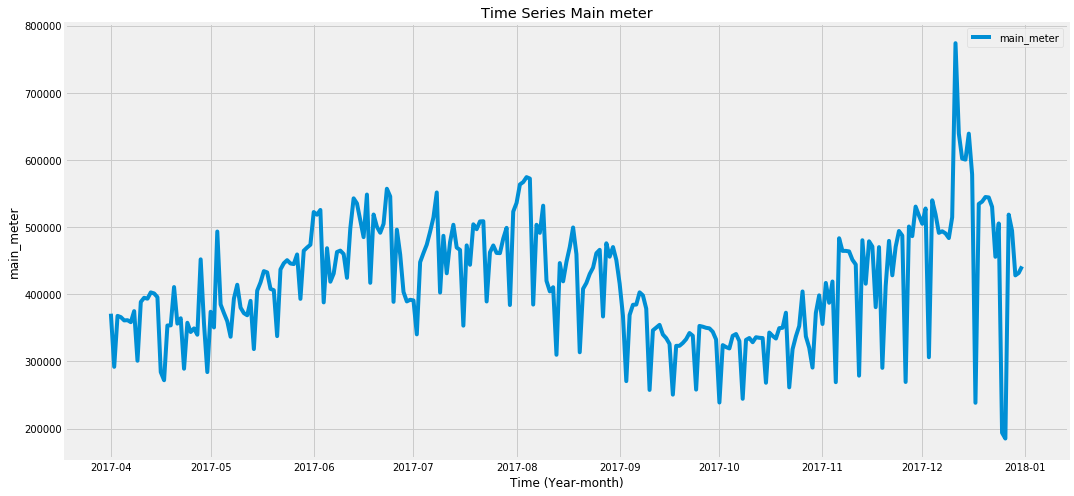

In [305]:
dataframe.index = dataframe['timestamp']
time_series = dataframe['main_meter']
plt.figure(figsize=(16,8))
plt.plot(time_series,label='main_meter')
plt.title('Time Series Main meter')
plt.xlabel('Time (Year-month)')
plt.ylabel('main_meter')
plt.legend(loc='best')

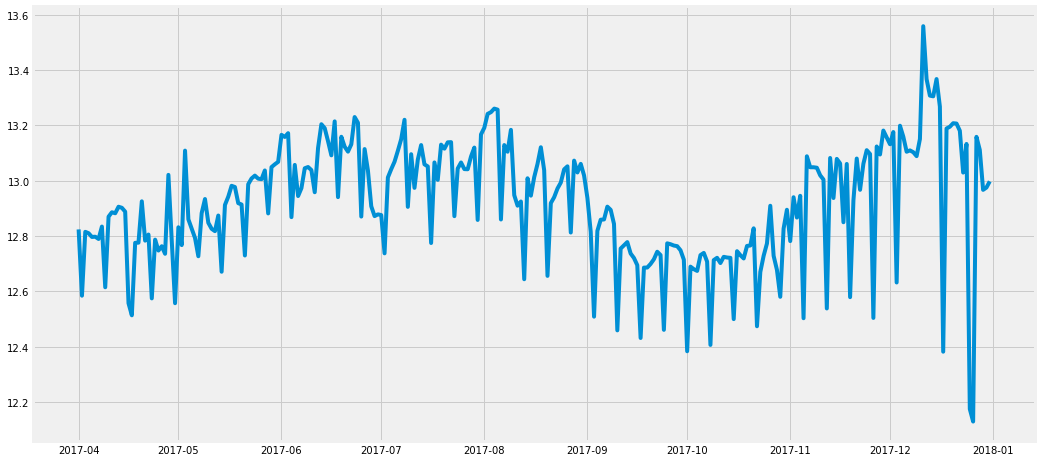

In [306]:
#Scaled down the values lograthimically
timeseries_log = np.log(time_series)
plt.figure(figsize=(16,8))
plt.plot(timeseries_log)

## First Diffrence

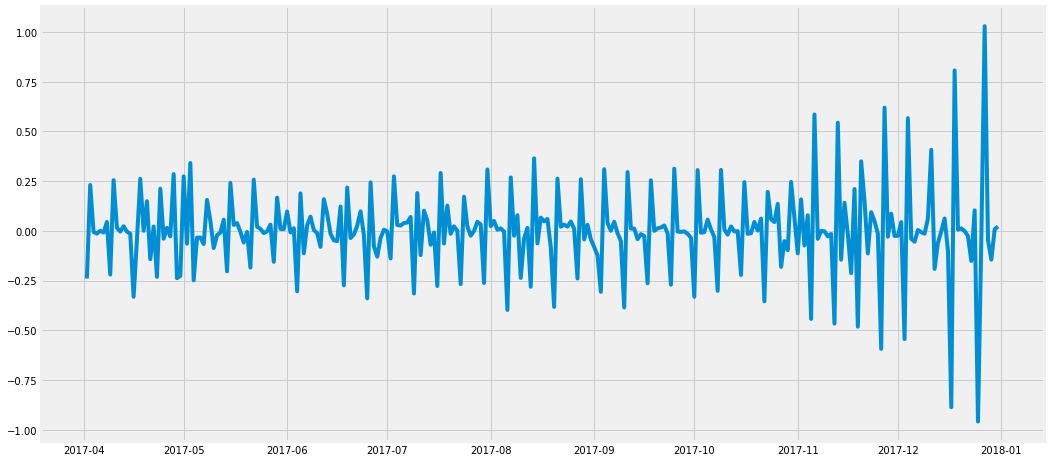

In [307]:
#Applying first diffrence to the data
timeseries_log_diff = timeseries_log - timeseries_log.shift()
plt.figure(figsize=(16,8))
plt.plot(timeseries_log_diff)

# Seasonality Decomposition

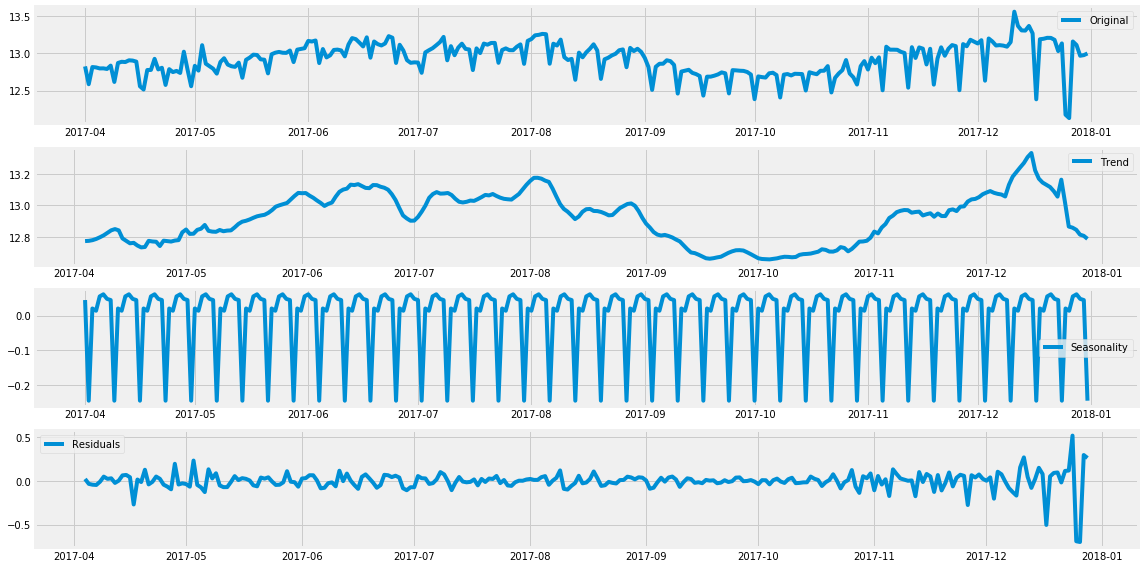

In [314]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(timeseries_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,8))
plt.subplot(411)
plt.plot(timeseries_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [319]:
from numpy import newaxis
from keras.layers.core import Dense ,Activation,Dropout
from keras.layers.recurrent import LSTM,GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler

## LSTM

In [440]:
##LSTM forecasting for the data

#splitting into train and test data
train_data = time_series[:len(timeseries_log)-40]
train_data = pd.DataFrame(train_data).values.reshape(-1,1)
test_data = time_series[len(timeseries_log)-40:]
test_data = pd.DataFrame(test_data).values.reshape(-1,1)

#starting with intialization 
scaler = MinMaxScaler()

scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [441]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 100
n_features = 1
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data,length=n_input,batch_size=1)

In [443]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import losses

lstm_model = Sequential()
lstm_model.add(LSTM(200,activation='relu',input_shape=(n_input,n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam',loss='mse')
lstm_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [444]:
lstm_model.fit_generator(generator,epochs=30)

Epoch 1/30
135/135 [==============================] - 5s 40ms/step - loss: 0.0654
Epoch 2/30
135/135 [==============================] - 5s 34ms/step - loss: 0.0336
Epoch 3/30
135/135 [==============================] - 5s 40ms/step - loss: 0.0341
Epoch 4/30
135/135 [==============================] - 5s 38ms/step - loss: 0.0314
Epoch 5/30
135/135 [==============================] - 5s 36ms/step - loss: 0.0301
Epoch 6/30
135/135 [==============================] - 6s 44ms/step - loss: 0.0319
Epoch 7/30
135/135 [==============================] - 6s 47ms/step - loss: 0.0305
Epoch 8/30
135/135 [==============================] - 6s 45ms/step - loss: 0.0291
Epoch 9/30
135/135 [==============================] - 6s 47ms/step - loss: 0.0291
Epoch 10/30
135/135 [==============================] - 6s 45ms/step - loss: 0.0313
Epoch 11/30
135/135 [==============================] - 6s 46ms/step - loss: 0.0330
Epoch 12/30
135/135 [==============================] - 6s 46ms/step - loss: 0.0283
Epoch 13/30
1

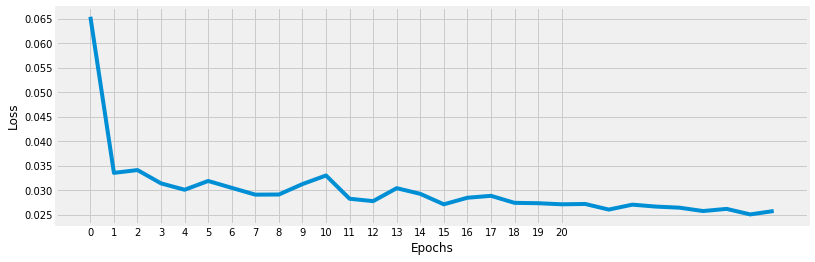

In [445]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [446]:
lstm_predictions_scaled = list()
batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1,n_input,n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [448]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [449]:
lstm_predictions = pd.Series(lstm_predictions.reshape(1,-1)[0])

In [451]:
lstm_predictions.index = time_series[-40:].index

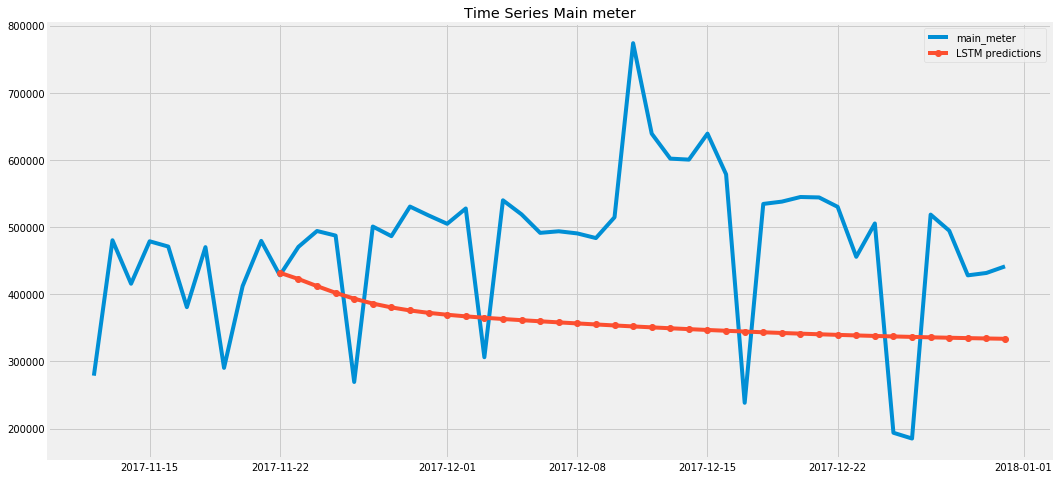

In [529]:
##Visualizing predictions by LSTM
plt.figure(figsize=(16,8))
plt.plot(time_series[-50:],label='main_meter')
plt.plot(lstm_predictions,marker='o',label='LSTM predictions')
plt.title('Time Series Main meter')
plt.legend(loc='best')

In [555]:
#calculating metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

mean_squared_error_lstm = mse(test_data,lstm_predictions)
mean_squared_log_error_lstm = msle(test_data,lstm_predictions)

## GRU

In [545]:
from keras.layers import GRU
gru_model = Sequential()
gru_model.add(GRU(300,activation='relu',input_shape=(n_input,n_features)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam',loss='mse')
gru_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 300)               271800    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 301       
Total params: 272,101
Trainable params: 272,101
Non-trainable params: 0
_________________________________________________________________


In [546]:
gru_model.fit_generator(generator,epochs=30)

Epoch 1/30
135/135 [==============================] - 28s 211ms/step - loss: 0.0381
Epoch 2/30
135/135 [==============================] - 27s 198ms/step - loss: 0.0321
Epoch 3/30
135/135 [==============================] - 25s 184ms/step - loss: 0.0296
Epoch 4/30
135/135 [==============================] - 25s 186ms/step - loss: 0.0299
Epoch 5/30
135/135 [==============================] - 26s 195ms/step - loss: 0.0304
Epoch 6/30
135/135 [==============================] - 25s 187ms/step - loss: 0.0263
Epoch 7/30
135/135 [==============================] - 24s 180ms/step - loss: 0.0303
Epoch 8/30
135/135 [==============================] - 25s 188ms/step - loss: 0.0306
Epoch 9/30
135/135 [==============================] - 25s 183ms/step - loss: 0.0300
Epoch 10/30
135/135 [==============================] - 26s 190ms/step - loss: 0.0282
Epoch 11/30
135/135 [==============================] - 26s 191ms/step - loss: 0.0280
Epoch 12/30
135/135 [==============================] - 25s 187ms/step - lo

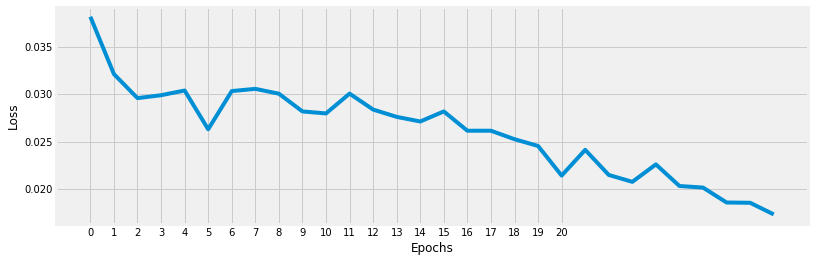

In [549]:
losses_gru = gru_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_gru)),losses_gru);

In [550]:
gru_predictions_scaled = list()
batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1,n_input,n_features))

for i in range(len(test_data)):   
    gru_pred = gru_model.predict(current_batch)[0]
    gru_predictions_scaled.append(gru_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[gru_pred]],axis=1)

In [551]:
gru_predictions = scaler.inverse_transform(gru_predictions_scaled)
gru_predictions = pd.Series(gru_predictions.reshape(1,-1)[0])
gru_predictions.index = time_series[-40:].index

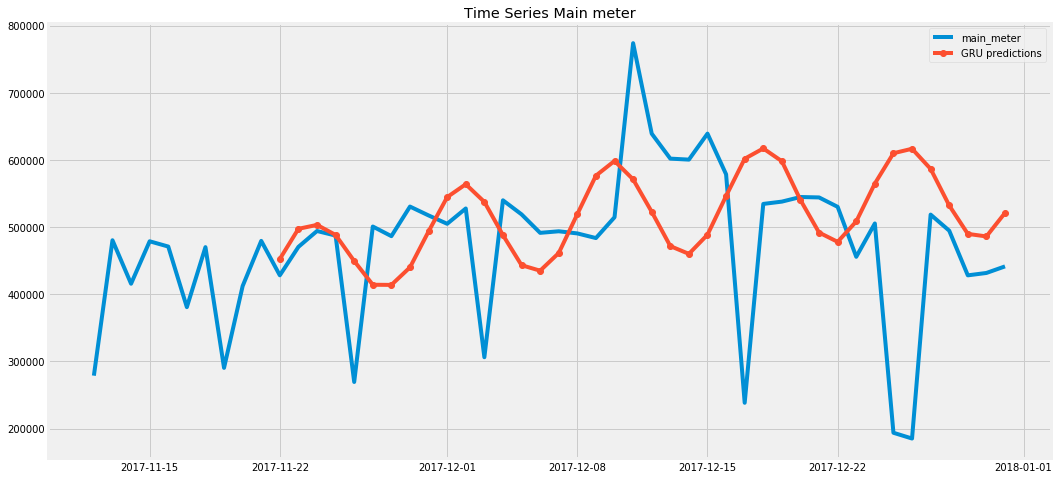

In [552]:
##Visualizing predictions by GRU
plt.figure(figsize=(16,8))
plt.plot(time_series[-50:],label='main_meter')
plt.plot(gru_predictions,marker='o',label='GRU predictions')
plt.title('Time Series Main meter')
plt.legend(loc='best')

In [560]:
#calculating metrics
mean_squared_error_gru = mse(test_data,gru_predictions)
mean_squared_log_error_gru = msle(test_data,gru_predictions)

## Auto Arima

In [455]:
from pmdarima.arima import auto_arima

In [458]:
stepwise_model =auto_arima(time_series[:-40], start_p=0, start_q=0,start_P=0,start_Q=0,
                           max_p=4, max_q=4,max_P=3,max_Q=3,m=7,
                           seasonal=True,d=1,
                           D=1,trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False,random_state=0)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=5542.198, BIC=5549.048, Fit time=1.557 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=5471.388, BIC=5481.663, Fit time=0.086 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 2, 7); AIC=5471.755, BIC=5485.455, Fit time=0.218 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 3, 7); AIC=5473.488, BIC=5490.613, Fit time=0.518 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=5502.024, BIC=5512.299, Fit time=0.067 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=5471.992, BIC=5485.692, Fit time=0.108 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 7); AIC=5472.717, BIC=5489.842, Fit time=0.288 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 3, 7); AIC=5474.714, BIC=5495.263, Fit time=0.482 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 1, 0, 7); AIC=5479.492, BIC=5493.192, Fit time=0.103 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_o

Fit ARIMA: order=(1, 1, 3) seasonal_order=(0, 1, 1, 7); AIC=5461.903, BIC=5485.878, Fit time=0.516 seconds
Fit ARIMA: order=(1, 1, 3) seasonal_order=(1, 1, 0, 7); AIC=5489.258, BIC=5513.232, Fit time=0.454 seconds
Fit ARIMA: order=(1, 1, 4) seasonal_order=(0, 1, 0, 7); AIC=5526.777, BIC=5550.751, Fit time=0.408 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=5534.635, BIC=5548.334, Fit time=0.057 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 7); AIC=5460.056, BIC=5477.181, Fit time=0.148 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 2, 7); AIC=5461.123, BIC=5481.673, Fit time=0.407 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 3, 7); AIC=5463.076, BIC=5487.050, Fit time=0.597 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=5489.041, BIC=5506.166, Fit time=0.145 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(1, 1, 1, 7); AIC=5461.185, BIC=5481.735, Fit time=0.330 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_o

In [526]:
stepwise_model.fit(time_series[:-40])
arima_predictions = stepwise_model.predict(n_periods=40)
arima_predictions = pd.Series(arima_predictions)
arima_predictions.index = time_series[-40:].index

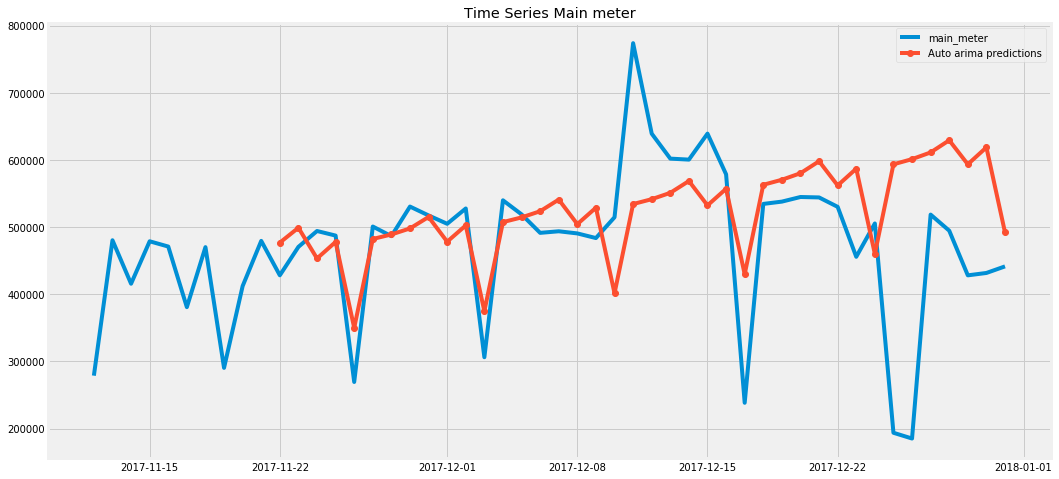

In [527]:
##Visualizing predictions by arima
plt.figure(figsize=(16,8))
plt.plot(time_series[-50:],label='main_meter')
plt.plot(arima_predictions,marker='o',label='Auto arima predictions')
plt.title('Time Series Main meter')
plt.legend(loc='best')

In [547]:
#calculating metrics
mean_squared_error_arima = mse(test_data,arima_predictions)
mean_squared_log_error_arima = msle(test_data,arima_predictions)

## TBATS

In [467]:
from tbats import TBATS
estimator = TBATS(seasonal_periods=(0.5,7))
model = estimator.fit(time_series[:-40])
tbats_predictions = model.forecast(steps=40)

In [469]:
tbats_predictions = pd.Series(tbats_predictions)
tbats_predictions.index = time_series[-40:].index

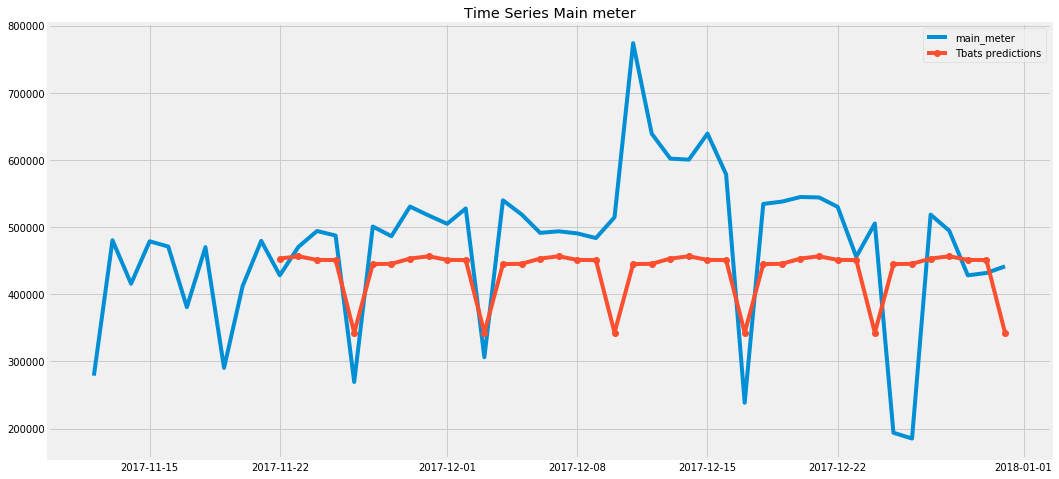

In [528]:
##Visualizing predictions by arima
plt.figure(figsize=(16,8))
plt.plot(time_series[-50:],label='main_meter')
plt.plot(tbats_predictions,marker='o',label='Tbats predictions')
plt.title('Time Series Main meter')
plt.legend(loc='best')

In [557]:
#calculating metrics
mean_squared_error_tbats = mse(test_data,tbats_predictions)
mean_squared_log_error_tbats = msle(test_data,tbats_predictions)

## Prophet

In [539]:
ts = pd.DataFrame(time_series)
ts = ts.reset_index(drop=True)
ts = pd.concat([pd.DataFrame(time_series.index),ts],axis=1)
ts.columns = ['ds','y'] # To use prophet column names should be like that 
train_data_pr = ts.iloc[:len(time_series)-40]
test_data_pr = ts.iloc[len(time_series)-40:]
from fbprophet import Prophet
model = Prophet()
model.fit(train_data_pr)
future = model.make_future_dataframe(periods=40,freq='D')
prophet_predictions = model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [540]:
prophet_predictions = pd.DataFrame({"Date" : prophet_predictions[-40:]['ds'], "Pred" : prophet_predictions[-40:]["yhat"]})
prophet_predictions = prophet_predictions.set_index("Date")

In [541]:
prophet_predictions = prophet_predictions.iloc[:,0]

In [542]:
prophet_predictions.index = time_series[-40:].index

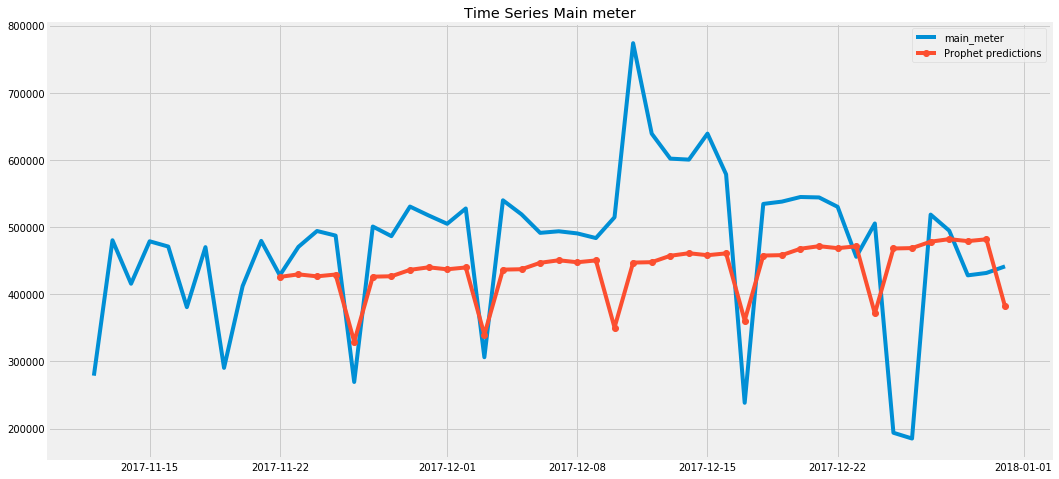

In [543]:
##Visualizing predictions by arima
plt.figure(figsize=(16,8))
plt.plot(time_series[-50:],label='main_meter')
plt.plot(prophet_predictions,marker='o',label='Prophet predictions')
plt.title('Time Series Main meter')
plt.legend(loc='best')

In [548]:
#calculating metrics
mean_squared_error_prophet = mse(test_data,prophet_predictions)
mean_squared_log_error_prophet = msle(test_data,prophet_predictions)

In [571]:
mean_squared_errors =[mean_squared_error_lstm,mean_squared_error_gru,mean_squared_error_arima,mean_squared_error_tbats,mean_squared_error_prophet]
mean_squared_log_errors =[mean_squared_log_error_lstm,mean_squared_log_error_gru,mean_squared_log_error_arima,mean_squared_log_error_tbats,mean_squared_log_error_prophet]
mean_errors = pd.concat([pd.DataFrame(mean_squared_errors),pd.DataFrame(mean_squared_log_errors)],axis=1)
mean_errors.columns = ['mean_squared_error','mean_squared_log_error']
mean_errors.index = ['LSTM','GRU','Arima','Tbats','Prophet']

In [573]:
mean_errors

,mean_squared_error,mean_squared_log_error
LSTM,3.019424e+10,0.162668
GRU,1.970715e+10,0.122943
Arima,1.519349e+10,0.096315
Tbats,1.367235e+10,0.080264
Prophet,1.395951e+10,0.082879
